<a href="https://colab.research.google.com/github/NahidurRahaman/Machine_Learning/blob/main/balance_fer2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset # Import TensorDataset here
import matplotlib.pyplot as plt
import pandas as pd
import os
import timm # Import timm library

In [2]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/fer2013.csv')  # columns: image_path, emotion, pupil_size, muscle_movement



In [5]:
print("📄 Dataset loaded:", df.shape)
print("🧠 Available columns:", df.columns)

📄 Dataset loaded: (35887, 3)
🧠 Available columns: Index(['emotion', 'pixels', 'Usage'], dtype='object')


In [6]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import numpy as np # Import numpy here
X = np.array([np.fromstring(p, sep=' ') for p in df['pixels']])
y = df['emotion'].values

print("\nBefore balancing:", Counter(y))


Before balancing: Counter({np.int64(3): 8989, np.int64(6): 6198, np.int64(4): 6077, np.int64(2): 5121, np.int64(0): 4953, np.int64(5): 4002, np.int64(1): 547})


In [7]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("After oversampling:", Counter(y_resampled))

After oversampling: Counter({np.int64(0): 8989, np.int64(2): 8989, np.int64(4): 8989, np.int64(6): 8989, np.int64(3): 8989, np.int64(5): 8989, np.int64(1): 8989})


In [8]:
from sklearn.model_selection import train_test_split

# মোট 30% test+val, তাই প্রথমে সেটা আলাদা করি
X_train, X_temp, y_train, y_temp = train_test_split(
    X_resampled, y_resampled,
    test_size=0.30,  # 30% temp (will split into val + test)
    random_state=42,
    stratify=y_resampled
)

# এখন temp (30%) থেকে অর্ধেক (15%) test, অর্ধেক (15%) val
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,  # 50% of 30% = 15% of total
    random_state=42,
    stratify=y_temp
)

print("✅ Data Split Completed:")
print(f"Train: {len(X_train)} samples ({len(X_train)/len(X_resampled)*100:.1f}%)")
print(f"Val:   {len(X_val)} samples ({len(X_val)/len(X_resampled)*100:.1f}%)")
print(f"Test:  {len(X_test)} samples ({len(X_test)/len(X_resampled)*100:.1f}%)")

✅ Data Split Completed:
Train: 44046 samples (70.0%)
Val:   9438 samples (15.0%)
Test:  9439 samples (15.0%)


In [9]:
# 5️⃣ Define Transformations
# ======================================================
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Note: Normalization for grayscale, might need adjustment for RGB
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Note: Normalization for grayscale, might need adjustment for RGB
])

# ======================================================
# 6️⃣ Helper Function: Apply transform & convert to tensor
# ======================================================
def transform_numpy_images(X, transform):
    from PIL import Image # Import PIL Image here
    transformed = []
    for x in X:
        # Convert to RGB (3 channels) instead of L (grayscale)
        img = Image.fromarray(x.reshape(48, 48).astype(np.uint8)).convert("RGB")
        img_tensor = transform(img)
        transformed.append(img_tensor)
    return torch.stack(transformed)

# Apply transforms and convert labels to tensors
X_train_tensor = transform_numpy_images(X_train, train_transform)
y_train_tensor = torch.tensor(y_train, dtype=torch.long) # Convert y_train to tensor

X_val_tensor = transform_numpy_images(X_val, test_transform)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)   # Convert y_val to tensor

X_test_tensor = transform_numpy_images(X_test, test_transform)
y_test_tensor = torch.tensor(y_test, dtype=torch.long) # Convert y_test to tensor

In [10]:
# Labels to tensor
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [11]:
# ======================================================
# 7️⃣ Create TensorDatasets
# ======================================================
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [12]:
# Create DataLoaders using the datasets defined in cell RLlP9My3svZ4

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print("✅ Train samples:", len(train_dataset))
print("✅ Val samples:", len(val_dataset))
print("✅ Test samples:", len(test_dataset))

✅ Train samples: 44046
✅ Val samples: 9438
✅ Test samples: 9439


In [13]:
for imgs, labels in train_loader:
    print("Batch image shape:", imgs.shape)
    print("Batch label shape:", labels.shape)
    break
# You should see: torch.Size([64, 3, 48, 48])


Batch image shape: torch.Size([64, 3, 48, 48])
Batch label shape: torch.Size([64])


In [ ]:
import torch.nn.functional as F

In [14]:
class EfficientNetV2S_FeatureExtractor(nn.Module):
    def __init__(self):
        super(EfficientNetV2S_FeatureExtractor, self).__init__()
        self.backbone = timm.create_model('tf_efficientnetv2_s.in21k', pretrained=True, features_only=True)

    def forward(self, x):
        features = self.backbone(x)
        return features[-1]

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
efficientnet_model = EfficientNetV2S_FeatureExtractor().to(device)
efficientnet_model.eval()

# Use first batch from train_loader
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        features = efficientnet_model(images)

    print("Input shape:", images.shape)
    print("EfficientNetV2-S Output shape:", features.shape)
    break

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/193M [00:00<?, ?B/s]

Input shape: torch.Size([64, 3, 48, 48])
EfficientNetV2-S Output shape: torch.Size([64, 256, 2, 2])


In [16]:
class ConvNeXtBlock(nn.Module):
    def __init__(self, in_channels=256, out_channels=256):
        super(ConvNeXtBlock, self).__init__()
        self.convnext = timm.create_model('convnext_tiny', pretrained=True, features_only=True)
        self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.proj(x)
        return x

In [17]:
class SE_MBConvBlock(nn.Module):
    def __init__(self, in_channels=256, out_channels=256):
        super(SE_MBConvBlock, self).__init__()
        self.expand = nn.Conv2d(in_channels, in_channels * 6, kernel_size=1)
        self.depthwise = nn.Conv2d(in_channels * 6, in_channels * 6, kernel_size=3, padding=1, groups=in_channels * 6)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels * 6, in_channels // 4, 1),
            nn.ReLU(),
            nn.Conv2d(in_channels // 4, in_channels * 6, 1),
            nn.Sigmoid()
        )
        self.project = nn.Conv2d(in_channels * 6, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.expand(x)
        x = self.depthwise(x)
        se_weight = self.se(x)
        x = x * se_weight
        x = self.project(x)
        return x  # shape: B × 256 × 7 × 7

In [18]:
adaptive_pool = nn.AdaptiveAvgPool2d((28, 28))

In [19]:
class MultiBranchFeatureExtractor(nn.Module):
    def __init__(self):
        super(MultiBranchFeatureExtractor, self).__init__()
        self.efficientnet = EfficientNetV2S_FeatureExtractor()
        self.convnext_block = ConvNeXtBlock()
        self.se_mbconv_block = SE_MBConvBlock()
        self.pool = nn.AdaptiveAvgPool2d((28, 28))  # Resize to 28×28

    def forward(self, x):
        x = self.efficientnet(x)  # Output: B × 1280 × 7 × 7

        convnext_feat = self.convnext_block(x)     # B × 256 × 7 × 7
        senet_feat    = self.se_mbconv_block(x)    # B × 256 × 7 × 7

        convnext_feat = self.pool(convnext_feat)   # B × 256 × 28 × 28
        senet_feat    = self.pool(senet_feat)      # B × 256 × 28 × 28

        return convnext_feat, senet_feat

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiBranchFeatureExtractor().to(device)
model.eval()

for images, labels in train_loader:
    images = images.to(device)

    with torch.no_grad():
        conv_feat, se_feat = model(images)

    print("ConvNeXt Output:", conv_feat.shape)  # [B, 256, 28, 28]
    print("SENet+MBConv Output:", se_feat.shape)  # [B, 256, 28, 28]
    break


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

ConvNeXt Output: torch.Size([64, 256, 28, 28])
SENet+MBConv Output: torch.Size([64, 256, 28, 28])


In [21]:
class CrossAttentionFusion(nn.Module):
    def __init__(self, embed_dim=256, num_heads=4):
        super(CrossAttentionFusion, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, feat_q, feat_kv):
        # Input: B × 256 × 28 × 28
        B, C, H, W = feat_q.shape

        # Flatten to sequences: B × 784 × 256
        q = feat_q.view(B, C, -1).permute(0, 2, 1)   # Q: (B, 784, 256)
        kv = feat_kv.view(B, C, -1).permute(0, 2, 1) # K,V: (B, 784, 256)

        # Cross-attention
        attn_output, _ = self.attn(q, kv, kv)        # (B, 784, 256)
        attn_output = self.norm(attn_output + q)     # Residual + Norm

        # Reshape back to spatial map: (B, 256, 28, 28)
        fused = attn_output.permute(0, 2, 1).view(B, C, H, W)

        return fused  # Output: B × 256 × 28 × 28

In [22]:
class FullFeatureFusionBlock(nn.Module):
    def __init__(self):
        super(FullFeatureFusionBlock, self).__init__()
        self.backbone = MultiBranchFeatureExtractor()        # Gives conv_feat, se_feat
        self.cross_attn = CrossAttentionFusion(embed_dim=256, num_heads=4)

    def forward(self, x):
        conv_feat, se_feat = self.backbone(x)               # B × 256 × 28 × 28

        fused_feat = self.cross_attn(conv_feat, se_feat)    # B × 256 × 28 × 28

        return fused_feat  # ready for concatenation with other branches if needed

In [23]:
model = FullFeatureFusionBlock().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        fused_output = model(images)

    print("Fused Output Shape:", fused_output.shape)  # Expected: [B, 256, 28, 28]
    break

Fused Output Shape: torch.Size([64, 256, 28, 28])


In [24]:
class GlobalContextBranch(nn.Module):
    def __init__(self, in_channels=256, out_channels=64):
        super(GlobalContextBranch, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1),
            nn.ReLU(),
            nn.Upsample(size=(28, 28), mode='bilinear', align_corners=False)
        )

    def forward(self, x):
        x = self.global_pool(x)   # [B, 256, 1, 1] after global pool, originally [B, 256, 7, 7]
        x = self.fc(x)            # [B, 64, 28, 28]
        return x

In [25]:
class LocalDetailBranch(nn.Module):
    def __init__(self, in_channels=256, out_channels=64):
        super(LocalDetailBranch, self).__init__()
        self.local_cnn = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.local_cnn(x)  # [B, 64, 28, 28]

In [26]:
class MultiBranchFullFusion(nn.Module):
    def __init__(self):
        super(MultiBranchFullFusion, self).__init__()
        self.feature_extractor = EfficientNetV2S_FeatureExtractor()

        self.convnext_block = ConvNeXtBlock()
        self.se_mbconv_block = SE_MBConvBlock()

        self.pool = nn.AdaptiveAvgPool2d((28, 28))
        self.cross_attn = CrossAttentionFusion(embed_dim=256)

        self.global_context = GlobalContextBranch()
        self.local_detail = LocalDetailBranch()

        # Add pooling to ensure consistent spatial dimensions before concatenation
        self.global_pool_out = nn.AdaptiveAvgPool2d((28, 28))
        self.local_pool_out = nn.AdaptiveAvgPool2d((28, 28))


    def forward(self, x):
        feat = self.feature_extractor(x)                # [B, 256, 7, 7]

        # ConvNeXt & SENet+MBConv
        conv_feat = self.pool(self.convnext_block(feat))  # [B, 256, 28, 28]
        se_feat   = self.pool(self.se_mbconv_block(feat)) # [B, 256, 28, 28]

        # Cross-attention fused output
        fused_attn = self.cross_attn(conv_feat, se_feat)  # [B, 256, 28, 28]

        # Extra branches
        global_feat = self.global_context(feat)           # Expected: [B, 64, 28, 28]
        local_feat  = self.local_detail(feat)             # Expected: [B, 64, 28, 28]

        # Ensure spatial dimensions are 28x28 before concatenation
        global_feat_pooled = self.global_pool_out(global_feat)
        local_feat_pooled = self.local_pool_out(local_feat)


        # Concatenate all
        final_feat = torch.cat([conv_feat, se_feat, fused_attn, global_feat_pooled, local_feat_pooled], dim=1)  # [B, 896, 28, 28]
        return final_feat

In [27]:
model = MultiBranchFullFusion().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        fusion_output = model(images)
    print("Final Fused Feature Shape:", fusion_output.shape)  # [B, 896, 28, 28]
    break


Final Fused Feature Shape: torch.Size([64, 896, 28, 28])


In [28]:
class MobileViTBlock(nn.Module):
    def __init__(self, in_channels, transformer_dim=128, patch_size=2, depth=2, heads=4):
        super(MobileViTBlock, self).__init__()
        self.patch_size = patch_size
        ph, pw = patch_size, patch_size

        self.local_rep = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )

        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        self.fold = nn.Fold(output_size=(28, 28), kernel_size=patch_size, stride=patch_size)

        self.conv_before_trans = nn.Conv2d(in_channels * ph * pw, transformer_dim, kernel_size=1)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=transformer_dim,
            nhead=heads,
            batch_first=True,
            dim_feedforward=transformer_dim * 2,
            dropout=0.1,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.conv_after_trans = nn.Conv2d(transformer_dim, in_channels * ph * pw, kernel_size=1)


        self.project = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )

    def forward(self, x):
        B, C, H, W = x.shape
        ph, pw = self.patch_size, self.patch_size

        identity = x # B × C × H × W

        x = self.local_rep(x) # B × C × H × W

        # Unfold, Conv, and flatten for Transformer
        x = self.unfold(x) # B × (C*ph*pw) × (H*W / (ph*pw))
        x = x.view(B, C, ph*pw, -1).permute(0, 3, 2, 1).contiguous().view(B, -1, C*ph*pw) # B × N × (C*ph*pw)
        x = self.conv_before_trans(x.permute(0, 2, 1).view(B, C*ph*pw, H//ph, W//pw)).view(B, self.conv_before_trans.out_channels, -1).permute(0, 2, 1) # B × N × transformer_dim


        # Transformer
        x = self.transformer(x) # B × N × transformer_dim

        # Project back and Fold
        x = self.conv_after_trans(x.permute(0, 2, 1).view(B, self.conv_after_trans.in_channels, H//ph, W//pw)) # B × (C*ph*pw) × H/ph × W/pw
        x = x.view(B, C*ph*pw, -1) # B × (C*ph*pw) × N
        x = self.fold(x) # B × C × H × W

        # Project and Residual Connection
        x = self.project(x) # B × C × H × W
        x = x + identity # Residual connection

        return x # B × in_channels × H × W

In [29]:
class FinalModelWithMobileViT(nn.Module):
    def __init__(self):
        super(FinalModelWithMobileViT, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=2, depth=2, heads=4)

    def forward(self, x):
        x = self.fusion(x)         # [B, 896, 28, 28]
        x = self.mobilevit(x)      # [B, 896, 28, 28]
        return x


In [30]:
class FinalModelWithMobileViT1(nn.Module):
    def __init__(self):
        super(FinalModelWithMobileViT1, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=(2,2), depth=2, heads=4)

    def forward(self, x):
        x = self.fusion(x)         # [B, 896, 28, 28]
        x = self.mobilevit(x)      # [B, 896, 28, 28]
        return x

In [31]:
class FinalModelWithGAP(nn.Module):
    def __init__(self):
        super(FinalModelWithGAP, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=2, depth=2, heads=4)
        self.gap = nn.AdaptiveAvgPool2d(1)  # Global Avg Pool → [B, 896, 1, 1]

    def forward(self, x):
        x = self.fusion(x)            # [B, 896, 28, 28]
        x = self.mobilevit(x)         # [B, 896, 28, 28]
        x = self.gap(x)               # [B, 896, 1, 1]
        x = x.view(x.size(0), -1)     # Flatten → [B, 896]
        return x

In [32]:
model = FinalModelWithGAP().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        features = model(images)

    print("Final Feature Vector Shape:", features.shape)  # [B, 896]
    break

Final Feature Vector Shape: torch.Size([64, 896])


In [33]:
class EmotionClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5, num_classes=7, out_ch=448):
        super().__init__()
        self.fusion = MultiBranchFullFusion()
        fused_ch = out_ch * 2
        self.project = nn.Conv2d(fused_ch, 896, kernel_size=1)
        self.mobilevit1 = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=2, depth=2, heads=4)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(896, 448),
            nn.ReLU(),
            nn.BatchNorm1d(448),
            nn.Dropout(dropout_rate),
            nn.Linear(448, 7)
        )
    def forward(self, x):
        x = self.fusion(x)      # [B, 2*out_ch, H, W]
        x = self.project(x)     # [B, 896, H, W]
        x = self.mobilevit1(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x


In [34]:
model = EmotionClassifier().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        logits = model(images)

    print("Model Output Shape:", logits.shape)  # [B, 7]
    break

Model Output Shape: torch.Size([64, 7])


In [35]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    val_loss = 0
    accuracy = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            accuracy += (predicted == target).sum().item()

        val_loss /= len(data_loader.dataset)
        accuracy = 100*accuracy /len(data_loader.dataset)
    return val_loss, accuracy

In [36]:
def train_model(
        model,
        train_loader, val_loader,
        criterion, optimizer,
        num_epochs,
        device,
        checkpoint_path
):
    model.train()

    best_val_accuracy = 0
    patience = 3
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    # Checkpoints
    checkpoint_dir = os.path.dirname(checkpoint_path)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in range(num_epochs):
        train_loss = 0
        train_correct = 0  # Initialize train_correct
        total = 0          # Initialize total
        for batch_idx, (pixel_batch, label_batch) in enumerate(train_loader):
            pixel_batch, label_batch = pixel_batch.to(device), label_batch.to(device)

            # Reshape pixel_batch to (batch_size, channels, height, width) for CNN
            # pixel_batch = pixel_batch.view(-1, 1, 48, 48) # REMOVE THIS LINE

            optimizer.zero_grad()
            output = model(pixel_batch)
            loss = criterion(output, label_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * pixel_batch.size(0)
            _, preds = torch.max(output, 1)
            train_correct += (preds == label_batch).sum().item()
            total += label_batch.size(0)


        train_acc = 100 * train_correct / total
        train_loss /= len(train_loader.dataset)
        val_loss, val_accuracy = evaluate_model(
            model=model,
            data_loader=val_loader,
            criterion=criterion,
            device=device
        )

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), checkpoint_path)
            print("Best parameter so far.")


        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_accuracy)
        history['train_acc'].append(train_acc)

        if patience == 0:
            """ Callback: Early stopping """
            print(f"Model performance is not improving. Exiting the training.")
            break

    return history # Return the history object

In [37]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer with weight decay
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=15, factor=0.5)

In [38]:
import os

checkpoint_path = os.path.join(
    os.getcwd(), "checkpoints", "/content/drive/MyDrive/checkpoints/best_model.pth"
)


In [39]:
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print("Model loaded successfully from checkpoints.")

Model loaded successfully from checkpoints.


In [40]:
history=train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50,
    device=device,
    checkpoint_path=checkpoint_path,
)


Best parameter so far.
Epoch [1/50] | Train Loss: 0.7081 | Train Acc: 89.45% | Val Loss: 0.0183 | Val Acc: 71.38%
Epoch [2/50] | Train Loss: 0.5590 | Train Acc: 95.20% | Val Loss: 0.0188 | Val Acc: 70.77%
Best parameter so far.
Epoch [3/50] | Train Loss: 0.5153 | Train Acc: 97.16% | Val Loss: 0.0187 | Val Acc: 72.10%
Epoch [4/50] | Train Loss: 0.5120 | Train Acc: 97.16% | Val Loss: 0.0193 | Val Acc: 70.84%
Best parameter so far.
Epoch [5/50] | Train Loss: 0.5113 | Train Acc: 97.25% | Val Loss: 0.0191 | Val Acc: 72.56%
Epoch [6/50] | Train Loss: 0.5063 | Train Acc: 97.50% | Val Loss: 0.0187 | Val Acc: 72.55%
Best parameter so far.
Epoch [7/50] | Train Loss: 0.5073 | Train Acc: 97.43% | Val Loss: 0.0184 | Val Acc: 74.13%
Epoch [8/50] | Train Loss: 0.5016 | Train Acc: 97.70% | Val Loss: 0.0182 | Val Acc: 73.47%
Epoch [9/50] | Train Loss: 0.4981 | Train Acc: 97.85% | Val Loss: 0.0185 | Val Acc: 73.48%
Epoch [10/50] | Train Loss: 0.4982 | Train Acc: 97.79% | Val Loss: 0.0186 | Val Acc: 73.4

In [41]:
import matplotlib.pyplot as plt

def plot_training(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

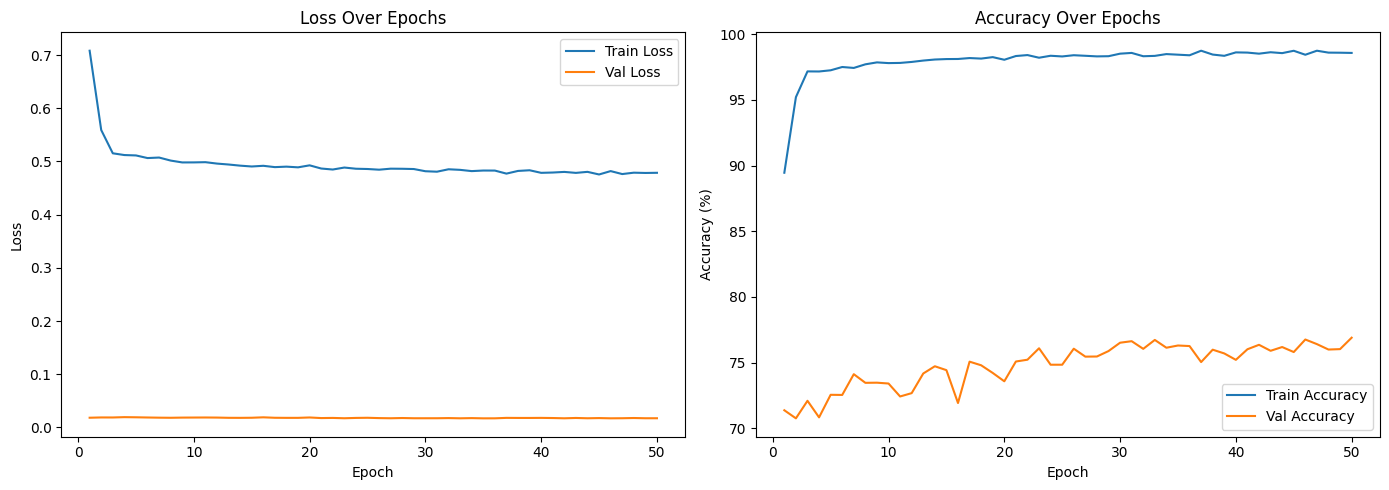

In [42]:
plot_training(history)

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def evaluate_on_test(model, test_loader, device, class_names=None):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Define all possible labels (0 to 6 for FER2013)
    all_possible_labels = list(range(len(class_names))) if class_names else sorted(list(set(all_labels + all_preds)))

    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, labels=all_possible_labels, zero_division=0)) # Added labels and zero_division

    # Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=all_possible_labels) # Added labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


📊 Classification Report:
              precision    recall  f1-score   support

       Angry       0.73      0.75      0.74      1348
     Disgust       0.96      1.00      0.98      1348
        Fear       0.66      0.69      0.67      1348
       Happy       0.79      0.83      0.81      1349
         Sad       0.67      0.58      0.62      1348
    Surprise       0.85      0.90      0.87      1348
     Neutral       0.70      0.63      0.67      1349

    accuracy                           0.77      9438
   macro avg       0.77      0.77      0.77      9438
weighted avg       0.77      0.77      0.77      9438



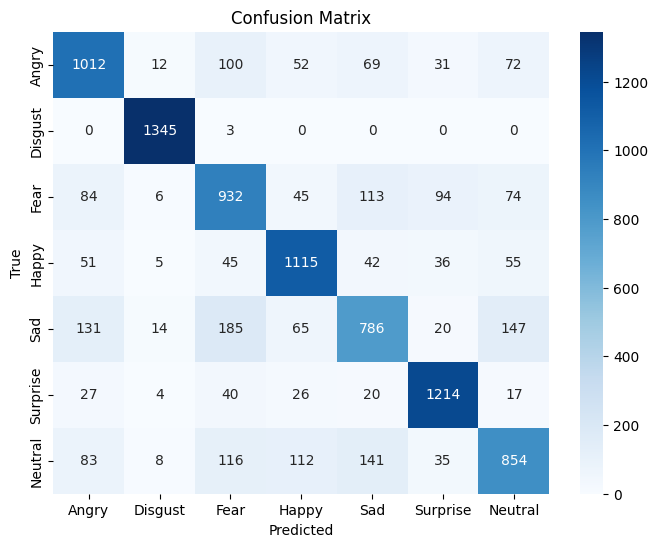

In [44]:
class_names = ['Angry', 'Disgust', 'Fear','Happy', 'Sad', 'Surprise', 'Neutral']
model.load_state_dict(torch.load(checkpoint_path))
evaluate_on_test(model, val_loader, device, class_names)